### File Explanation

**trainRNN_EncoderModel_dropout.ipynb:**
<br> This notebook is to load AddNeuroMed examples from 'preprocessData.pickle', create an "Encoder Network" and train the network with respect to a range of dropout rates

**Processes are as follows:**
<br> 1) Load all variables from 'preprocessData.pickle'
<br> 2) Parameter and hyperparameter assignments (location: **3rd cell**)
<br> 3) Create LSTM cells with Dropout Wrappers for gene A and gene B (function: **dropoutWrapper** in **trainRNN_network_utils.py**)
<br> 4) Using LSTM cells, create multi-layer dynamic model (function: **dynamicLSTM** using **length** in **trainRNN_network_utils.py**)
<br> 5) Create a single output by using the relevants outputs of encoder models of gene A and gene B 
<br> 6) Pass the output through a **dense** layer and make prediction with **softmax**
<br> 7) Before starting the training: concatenate rSnpG_tr_nXSN and rRnaG_nXS where G represents gene A and gene B (function: **input_reshape** in **trainRNN_utils.py**)
<br> 8) Train the network: every epoch (i.e., iteration) shuffle the data within each class (function: **shuffle_classes** in **trainRNN_utils.py**) and train in batches (function: **extract_batch_size** in **trainRNN_utils.py**)
<br> 9) Plot results with **plot_inputs** in **trainRNN_plot_utils.py**)
<br> 10) Save them in "resultsEncoderDropout_ANM.pickle" to be called when necessary

**Variables created:**
<br> 1) **trainLosses**: Train losses, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 2) **testLosses**: Test losses, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 3) **F1_scores**: F1_scores, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 4) **trainAccuracy**: Train accuracy, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])

In [1]:
import tensorflow as tf
from IPython.core.debugger import set_trace 
import numpy as np
import sys
import pandas as pd
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt

import os
os.environ[ "CUDA_VISIBLE_DEVICES" ] = "3"

%matplotlib inline

In [2]:
# LOAD DATA
# Load data form the pickle produced by "preprocessData.ipynb"

# Save data into Python file
import pickle
with open('preprocessData.pickle', 'rb') as f:
    rSnpA_nXSN = pickle.load( f )
    rSnpB_nXSN = pickle.load( f )
    rRnaA_nXS = pickle.load( f )
    rRnaB_nXS = pickle.load( f )
    rRelated_nXC = pickle.load( f )
    rSnpA_tr_nXSN = pickle.load( f )
    rSnpB_tr_nXSN = pickle.load( f )
    rRnaA_tr_nXS = pickle.load( f )
    rRnaB_tr_nXS = pickle.load( f )
    rRelated_tr_nXC = pickle.load( f )
    rSnpA_tst_nXSN = pickle.load( f )
    rSnpB_tst_nXSN = pickle.load( f )
    rRnaA_tst_nXS = pickle.load( f )
    rRnaB_tst_nXS = pickle.load( f )
    rRelated_tst_nXC = pickle.load( f )
    sGeneNames_nX2 = pickle.load( f )
    nRs = pickle.load( f )
    nSs = pickle.load( f )
    print( 'Data loaded from pickle.' )

# Check the input dimensions
assert( len( rSnpA_nXSN.shape ) == 3 )
assert( len( rSnpB_nXSN.shape ) == 3 )
assert( len( rRnaA_nXS.shape ) == 2 )
assert( len( rRnaB_nXS.shape ) == 2)
assert( len( rRelated_nXC.shape ) == 2 )
assert( len( rSnpA_tr_nXSN.shape ) == 3 )
assert( len( rSnpB_tr_nXSN.shape ) == 3 )
assert( len( rRnaA_tr_nXS.shape ) == 2 )
assert( len( rRnaB_tr_nXS.shape ) == 2 )
assert( len( rRelated_tr_nXC.shape ) == 2 )
assert( len( rSnpA_tst_nXSN.shape ) == 3 )
assert( len( rSnpB_tst_nXSN.shape ) == 3 )
assert( len( rRnaA_tst_nXS.shape ) == 2 )
assert( len( rRnaB_tst_nXS.shape ) == 2 )
assert( len( rRelated_tst_nXC.shape ) == 2)
assert( rSnpA_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRelated_nXC.shape[ 0 ] )
assert( rSnpA_nXSN.shape[ 1 ] == rRnaA_nXS.shape[ 1 ] )
assert( rSnpB_nXSN.shape[ 1 ] == rRnaB_nXS.shape[ 1 ] )
assert( rRelated_nXC.shape[ 1 ] == 3 )

iSnum = rSnpA_nXSN.shape[ 1 ] # Number of subjects
iNnum = rSnpA_nXSN.shape[ 2 ] # Number of snps
iCnum = rRelated_nXC.shape[ 1 ] # Number of classes

print('All samples loaded' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC.shape[ 1 ] ) )

Data loaded from pickle.
All samples loaded
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 206
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


### Parameters

In [3]:
# Parameters

## Input data
time_steps = iNnum + 1                              # number of snps + number of rnas
n_input = iSnum                                     # number of subjects

## LSTM's internal structure
n_hidden = 32                                       # number of nodes in hidden layer 
n_classes = iCnum                                   # number of classes
n_layer = 3                                         # number of layers
dropouts = [0.4, 0.5, 0.6, 0.7, 0.8]                # dropout percentage

## Training data
learning_rate = 0.001
batch_size = 150
n_epoch = 200
n_batch = rSnpA_tr_nXSN.shape[0] // batch_size   # number of batches
lambda_l2_reg = 0.0001

### Network and Train

In [8]:
%run trainRNN_utils.py
%run trainRNN_network_utils.py

trainLosses = {}
testLosses = {}
F1_scores = {}
trainAccuracy = {}
for dropout in dropouts:

    # Create network
    tf.reset_default_graph()

    # Gene A and Gene B input and output placeholders
    ## Input placeholders
    with tf.variable_scope('geneA'):

        rSnpRnaA_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])

        hidden_output_A, current_state_A = dynamicLSTM(rSnpRnaA_pXNS, 
                                                       n_layer, 
                                                       n_hidden, 
                                                       dropout)
        
        lastA = last_relevant(hidden_output_A, length(rSnpRnaA_pXNS))

    with tf.variable_scope('geneB'):

        rSnpRnaB_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])

        hidden_output_B, current_state_B = dynamicLSTM(rSnpRnaB_pXNS, 
                                                       n_layer, 
                                                       n_hidden, 
                                                       dropout)
        
        lastB = last_relevant(hidden_output_B, length(rSnpRnaB_pXNS))

    last = tf.math.add(lastA, lastB)

    rRelated_pXC = tf.placeholder(tf.float32, 
                                  shape = [None, iCnum],
                                  name = 'rRelated_pXC')  

    # Dense Layer
    logit = tf.layers.dense(last,
                            units = n_classes, 
                            activation = None,
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(0.3),
                            kernel_initializer = tf.initializers.random_normal() )

    prediction = tf.nn.softmax( logit )
    
    l2 = lambda_l2_reg * sum(
    tf.nn.l2_loss(tf_var)
        for tf_var in tf.trainable_variables()
        if not ("bias" in tf_var.name))

    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=prediction, 
                                                                         labels=tf.argmax(rRelated_pXC,1)) + l2)
    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Accuracy; precision, and recall for f1 score
    correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(rRelated_pXC,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    rec, rec_op = tf.metrics.recall(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))
    pre, pre_op = tf.metrics.precision(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())

        # Train the network 
        train_losses = []
        train_accuracies = []
        train_f1_score = [None] * n_epoch
        test_losses = []
        test_accuracies = []
        test_f1_score = []

        # Reshape and retrive the merged training and test data
        rSnpRnaA_tr_nXNS = input_reshape(rSnpA_tr_nXSN, rRnaA_tr_nXS)
        rSnpRnaB_tr_nXNS = input_reshape(rSnpB_tr_nXSN, rRnaB_tr_nXS)
        rSnpRnaA_tst_nXNS = input_reshape(rSnpA_tst_nXSN, rRnaA_tst_nXS)
        rSnpRnaB_tst_nXNS = input_reshape(rSnpB_tst_nXSN, rRnaB_tst_nXS)

        for epoch_idx in range(n_epoch): 

            print("Data shuffled." + \
                  " Epoch: ", epoch_idx)

            # Shuffle classes
            rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS = shuffle_classes(rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS)

            for batch_idx in range(n_batch):

                batch_rSnpRnaA_tXNS = extract_batch_size(rSnpRnaA_tr_nXNS, batch_idx, batch_size)
                batch_rSnpRnaB_tXNS = extract_batch_size(rSnpRnaB_tr_nXNS, batch_idx, batch_size)
                batch_rRelated_tXC = extract_batch_size(rRelated_tr_nXC, batch_idx, batch_size)

                # Fit training data
                opt, tr_loss, tr_acc = sess.run(
                    [optimiser, cost, accuracy], 
                    feed_dict = {
                        rSnpRnaA_pXNS: batch_rSnpRnaA_tXNS,
                        rSnpRnaB_pXNS: batch_rSnpRnaB_tXNS,
                        rRelated_pXC: batch_rRelated_tXC,
                    })

                tst_loss, tst_acc, tst_pre, _, tst_rec, _ = sess.run(
                    [cost, accuracy, pre, pre_op, rec, rec_op],
                    feed_dict = {
                        rSnpRnaA_pXNS: rSnpRnaA_tst_nXNS,
                        rSnpRnaB_pXNS: rSnpRnaB_tst_nXNS,
                        rRelated_pXC: rRelated_tst_nXC,
                    })            

                if batch_idx == (n_batch - 1):

                    train_losses.append(tr_loss)
                    train_accuracies.append(tr_acc)

                    tst_f1_score = 2 * ( tst_rec * tst_pre ) / (tst_rec + tst_pre) 

                    test_losses.append(tst_loss)
                    test_f1_score.append(tst_f1_score)

            print("Performance on training data" + 
                 ": Loss = {}".format(tr_loss) + 
                 ": Accuracy = {}".format( tr_acc ) )

            print("Performance on test set: " + 
                  ": Loss = {}".format(tst_loss) + 
                  ": Accuracy = {}".format(tst_f1_score) )
            print("")
    
        trainLosses[dropout] = train_losses
        testLosses[dropout] = test_losses
        trainAccuracy[dropout] = train_accuracies
        F1_scores[dropout] = test_f1_score
        print("Optimisation finished!")
        

Data shuffled. Epoch:  0
Performance on training data: Loss = 1.1489182710647583: Accuracy = 0.3733333349227905
Performance on test set: : Loss = 1.169175386428833: Accuracy = 0.7328989852084299

Data shuffled. Epoch:  1
Performance on training data: Loss = 1.1526813507080078: Accuracy = 0.36000001430511475
Performance on test set: : Loss = 1.1301873922348022: Accuracy = 0.7002477366094566

Data shuffled. Epoch:  2
Performance on training data: Loss = 1.156346321105957: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.119622826576233: Accuracy = 0.7081080958666129

Data shuffled. Epoch:  3
Performance on training data: Loss = 1.1350940465927124: Accuracy = 0.3933333456516266
Performance on test set: : Loss = 1.2210521697998047: Accuracy = 0.7026807561926904

Data shuffled. Epoch:  4
Performance on training data: Loss = 1.1479483842849731: Accuracy = 0.30000001192092896
Performance on test set: : Loss = 1.1504347324371338: Accuracy = 0.6783355554185957

Data shuffled. E

Performance on training data: Loss = 0.8031954765319824: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 1.315459132194519: Accuracy = 0.5912272538165466

Data shuffled. Epoch:  43
Performance on training data: Loss = 0.8041287064552307: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 1.2205575704574585: Accuracy = 0.5892202089901821

Data shuffled. Epoch:  44
Performance on training data: Loss = 0.8466824889183044: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 1.2920774221420288: Accuracy = 0.5871458982590724

Data shuffled. Epoch:  45
Performance on training data: Loss = 0.8354341387748718: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 1.312315821647644: Accuracy = 0.5841766506671082

Data shuffled. Epoch:  46
Performance on training data: Loss = 0.7582243084907532: Accuracy = 0.8333333134651184
Performance on test set: : Loss = 1.2926729917526245: Accuracy = 0.5821758704087854

Data shuffled. Epoch:  47
Performance 

Performance on training data: Loss = 0.7618860006332397: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 1.3390765190124512: Accuracy = 0.5363179847519033

Data shuffled. Epoch:  85
Performance on training data: Loss = 0.7788218259811401: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 1.31064772605896: Accuracy = 0.5365969819803281

Data shuffled. Epoch:  86
Performance on training data: Loss = 0.7435980439186096: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 1.208732008934021: Accuracy = 0.5370658850608807

Data shuffled. Epoch:  87
Performance on training data: Loss = 0.7562851309776306: Accuracy = 0.8066666722297668
Performance on test set: : Loss = 1.2502450942993164: Accuracy = 0.5372541528672101

Data shuffled. Epoch:  88
Performance on training data: Loss = 0.7670244574546814: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 1.2945150136947632: Accuracy = 0.5369522700256313

Data shuffled. Epoch:  89
Performance o

Performance on training data: Loss = 0.7227587103843689: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 1.2738196849822998: Accuracy = 0.5408585175570193

Data shuffled. Epoch:  127
Performance on training data: Loss = 0.7605777382850647: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 1.2646974325180054: Accuracy = 0.5400608754361771

Data shuffled. Epoch:  128
Performance on training data: Loss = 0.7202180624008179: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 1.2580369710922241: Accuracy = 0.5392363845727055

Data shuffled. Epoch:  129
Performance on training data: Loss = 0.7718726992607117: Accuracy = 0.800000011920929
Performance on test set: : Loss = 1.2912472486495972: Accuracy = 0.5384438491543152

Data shuffled. Epoch:  130
Performance on training data: Loss = 0.7510030269622803: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 1.2724343538284302: Accuracy = 0.5375474770642452

Data shuffled. Epoch:  131
Perfor

Performance on training data: Loss = 0.6923621892929077: Accuracy = 0.8733333349227905
Performance on test set: : Loss = 1.2645981311798096: Accuracy = 0.5110869512105739

Data shuffled. Epoch:  169
Performance on training data: Loss = 0.7271338105201721: Accuracy = 0.8333333134651184
Performance on test set: : Loss = 1.2785751819610596: Accuracy = 0.5105166725238581

Data shuffled. Epoch:  170
Performance on training data: Loss = 0.7649983763694763: Accuracy = 0.8066666722297668
Performance on test set: : Loss = 1.2967339754104614: Accuracy = 0.5101042252139509

Data shuffled. Epoch:  171
Performance on training data: Loss = 0.7124229669570923: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 1.2667566537857056: Accuracy = 0.5098242404047274

Data shuffled. Epoch:  172
Performance on training data: Loss = 0.7213667631149292: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 1.2626653909683228: Accuracy = 0.5096140816284235

Data shuffled. Epoch:  173
Perfo

Performance on training data: Loss = 1.0144946575164795: Accuracy = 0.5066666603088379
Performance on test set: : Loss = 1.1816176176071167: Accuracy = 0.5459337540834011

Data shuffled. Epoch:  11
Performance on training data: Loss = 0.9969570636749268: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.16133713722229: Accuracy = 0.5384883352730551

Data shuffled. Epoch:  12
Performance on training data: Loss = 0.9205889105796814: Accuracy = 0.6200000047683716
Performance on test set: : Loss = 1.1754528284072876: Accuracy = 0.5301283545542557

Data shuffled. Epoch:  13
Performance on training data: Loss = 1.0184723138809204: Accuracy = 0.5133333206176758
Performance on test set: : Loss = 1.2136425971984863: Accuracy = 0.5205730185593365

Data shuffled. Epoch:  14
Performance on training data: Loss = 0.9680835008621216: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.2068252563476562: Accuracy = 0.5159354056402837

Data shuffled. Epoch:  15
Performance 

Performance on training data: Loss = 0.8427309393882751: Accuracy = 0.7266666889190674
Performance on test set: : Loss = 1.1762573719024658: Accuracy = 0.4551818321984429

Data shuffled. Epoch:  53
Performance on training data: Loss = 0.7888773083686829: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 1.161486268043518: Accuracy = 0.45507477670955

Data shuffled. Epoch:  54
Performance on training data: Loss = 0.8334481120109558: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 1.1186800003051758: Accuracy = 0.4591761396448541

Data shuffled. Epoch:  55
Performance on training data: Loss = 0.8408159613609314: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 1.1796787977218628: Accuracy = 0.46328769980422496

Data shuffled. Epoch:  56
Performance on training data: Loss = 0.8634097576141357: Accuracy = 0.7066666483879089
Performance on test set: : Loss = 1.12534761428833: Accuracy = 0.466933069707033

Data shuffled. Epoch:  57
Performance on 

Performance on training data: Loss = 0.8016291260719299: Accuracy = 0.7666666507720947
Performance on test set: : Loss = 1.1720761060714722: Accuracy = 0.5010180028991047

Data shuffled. Epoch:  95
Performance on training data: Loss = 0.8296991586685181: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 1.1380364894866943: Accuracy = 0.5019254807168834

Data shuffled. Epoch:  96
Performance on training data: Loss = 0.7871785759925842: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 1.2089649438858032: Accuracy = 0.5023593640989306

Data shuffled. Epoch:  97
Performance on training data: Loss = 0.8306542634963989: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 1.1796932220458984: Accuracy = 0.5028274010833731

Data shuffled. Epoch:  98
Performance on training data: Loss = 0.7859750986099243: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 1.1666258573532104: Accuracy = 0.5030043453661532

Data shuffled. Epoch:  99
Performanc

Performance on training data: Loss = 0.7576146721839905: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 1.139599323272705: Accuracy = 0.49302281906317813

Data shuffled. Epoch:  137
Performance on training data: Loss = 0.8302058577537537: Accuracy = 0.746666669845581
Performance on test set: : Loss = 1.1499078273773193: Accuracy = 0.4927358451320052

Data shuffled. Epoch:  138
Performance on training data: Loss = 0.755368709564209: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 1.1008883714675903: Accuracy = 0.4925650961965458

Data shuffled. Epoch:  139
Performance on training data: Loss = 0.7723703980445862: Accuracy = 0.800000011920929
Performance on test set: : Loss = 1.1151762008666992: Accuracy = 0.49238083955686696

Data shuffled. Epoch:  140
Performance on training data: Loss = 0.7372325658798218: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 1.061194896697998: Accuracy = 0.4929635874030455

Data shuffled. Epoch:  141
Performa

Performance on training data: Loss = 0.8978196978569031: Accuracy = 0.6733333468437195
Performance on test set: : Loss = 1.1261677742004395: Accuracy = 0.4977471244177066

Data shuffled. Epoch:  179
Performance on training data: Loss = 0.8473703265190125: Accuracy = 0.7266666889190674
Performance on test set: : Loss = 1.2161275148391724: Accuracy = 0.49783419033690746

Data shuffled. Epoch:  180
Performance on training data: Loss = 0.8122716546058655: Accuracy = 0.753333330154419
Performance on test set: : Loss = 1.2127386331558228: Accuracy = 0.497597088035421

Data shuffled. Epoch:  181
Performance on training data: Loss = 0.8074876666069031: Accuracy = 0.7666666507720947
Performance on test set: : Loss = 1.173516035079956: Accuracy = 0.4973937955356453

Data shuffled. Epoch:  182
Performance on training data: Loss = 0.7730739116668701: Accuracy = 0.800000011920929
Performance on test set: : Loss = 1.1705725193023682: Accuracy = 0.49733407786350453

Data shuffled. Epoch:  183
Perform

Performance on training data: Loss = 0.9466542601585388: Accuracy = 0.6333333253860474
Performance on test set: : Loss = 1.2405861616134644: Accuracy = 0.6507750977156624

Data shuffled. Epoch:  21
Performance on training data: Loss = 0.9559366106987: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.167708396911621: Accuracy = 0.6494453939942787

Data shuffled. Epoch:  22
Performance on training data: Loss = 0.9867839813232422: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.1748108863830566: Accuracy = 0.6518402376554391

Data shuffled. Epoch:  23
Performance on training data: Loss = 1.0193204879760742: Accuracy = 0.5133333206176758
Performance on test set: : Loss = 1.2268919944763184: Accuracy = 0.6527532289407633

Data shuffled. Epoch:  24
Performance on training data: Loss = 0.9140063524246216: Accuracy = 0.653333306312561
Performance on test set: : Loss = 1.1910972595214844: Accuracy = 0.6519553523345613

Data shuffled. Epoch:  25
Performance on 

Performance on training data: Loss = 0.8779822587966919: Accuracy = 0.699999988079071
Performance on test set: : Loss = 1.2000147104263306: Accuracy = 0.6736687303234073

Data shuffled. Epoch:  63
Performance on training data: Loss = 0.8724756836891174: Accuracy = 0.7133333086967468
Performance on test set: : Loss = 1.1988024711608887: Accuracy = 0.673973280043135

Data shuffled. Epoch:  64
Performance on training data: Loss = 0.9021328687667847: Accuracy = 0.6666666865348816
Performance on test set: : Loss = 1.2240816354751587: Accuracy = 0.6742820143971219

Data shuffled. Epoch:  65
Performance on training data: Loss = 0.8643184304237366: Accuracy = 0.6933333277702332
Performance on test set: : Loss = 1.2332561016082764: Accuracy = 0.6744203247165994

Data shuffled. Epoch:  66
Performance on training data: Loss = 0.8493301868438721: Accuracy = 0.7266666889190674
Performance on test set: : Loss = 1.212112307548523: Accuracy = 0.6746654951465385

Data shuffled. Epoch:  67
Performance o

Performance on training data: Loss = 0.8998371362686157: Accuracy = 0.6733333468437195
Performance on test set: : Loss = 1.2019095420837402: Accuracy = 0.7003692138812286

Data shuffled. Epoch:  105
Performance on training data: Loss = 0.8880672454833984: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.193311095237732: Accuracy = 0.700365743801919

Data shuffled. Epoch:  106
Performance on training data: Loss = 0.8464306592941284: Accuracy = 0.7266666889190674
Performance on test set: : Loss = 1.1666176319122314: Accuracy = 0.7007927708819418

Data shuffled. Epoch:  107
Performance on training data: Loss = 0.9000298976898193: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 1.230733036994934: Accuracy = 0.7011812826621495

Data shuffled. Epoch:  108
Performance on training data: Loss = 0.8509664535522461: Accuracy = 0.7266666889190674
Performance on test set: : Loss = 1.2107363939285278: Accuracy = 0.7016662902505578

Data shuffled. Epoch:  109
Performa

Performance on training data: Loss = 0.7977411150932312: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 1.176936149597168: Accuracy = 0.7167943495275996

Data shuffled. Epoch:  147
Performance on training data: Loss = 0.8681777119636536: Accuracy = 0.6933333277702332
Performance on test set: : Loss = 1.2029476165771484: Accuracy = 0.7169359514672287

Data shuffled. Epoch:  148
Performance on training data: Loss = 0.8301536440849304: Accuracy = 0.746666669845581
Performance on test set: : Loss = 1.1286909580230713: Accuracy = 0.7169997137150312

Data shuffled. Epoch:  149
Performance on training data: Loss = 0.8099558353424072: Accuracy = 0.753333330154419
Performance on test set: : Loss = 1.169956088066101: Accuracy = 0.7171321836784752

Data shuffled. Epoch:  150
Performance on training data: Loss = 0.8072646260261536: Accuracy = 0.7599999904632568
Performance on test set: : Loss = 1.1786741018295288: Accuracy = 0.7173438000952754

Data shuffled. Epoch:  151
Performan

Performance on training data: Loss = 0.8008019924163818: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 1.1483135223388672: Accuracy = 0.7156087488034748

Data shuffled. Epoch:  189
Performance on training data: Loss = 0.8291956782341003: Accuracy = 0.746666669845581
Performance on test set: : Loss = 1.1722928285598755: Accuracy = 0.715221887518095

Data shuffled. Epoch:  190
Performance on training data: Loss = 0.7811625599861145: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 1.209532618522644: Accuracy = 0.7146232642032998

Data shuffled. Epoch:  191
Performance on training data: Loss = 0.7654834985733032: Accuracy = 0.8066666722297668
Performance on test set: : Loss = 1.206209421157837: Accuracy = 0.7140930072750631

Data shuffled. Epoch:  192
Performance on training data: Loss = 0.8397760391235352: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 1.2152947187423706: Accuracy = 0.7135092505347733

Data shuffled. Epoch:  193
Performan

Performance on training data: Loss = 0.89864581823349: Accuracy = 0.6333333253860474
Performance on test set: : Loss = 1.256809949874878: Accuracy = 0.613410071204774

Data shuffled. Epoch:  31
Performance on training data: Loss = 0.9346818327903748: Accuracy = 0.6266666650772095
Performance on test set: : Loss = 1.2796452045440674: Accuracy = 0.610053764329297

Data shuffled. Epoch:  32
Performance on training data: Loss = 0.8947221636772156: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.214214563369751: Accuracy = 0.6046689656145212

Data shuffled. Epoch:  33
Performance on training data: Loss = 0.9003534913063049: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 1.2538660764694214: Accuracy = 0.6001068118850849

Data shuffled. Epoch:  34
Performance on training data: Loss = 0.8963569402694702: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 1.222762942314148: Accuracy = 0.5969464738023048

Data shuffled. Epoch:  35
Performance on tr

Performance on training data: Loss = 0.8333730101585388: Accuracy = 0.7666666507720947
Performance on test set: : Loss = 1.209091067314148: Accuracy = 0.5349562163150704

Data shuffled. Epoch:  73
Performance on training data: Loss = 0.8694427609443665: Accuracy = 0.7066666483879089
Performance on test set: : Loss = 1.2357176542282104: Accuracy = 0.5339010090836379

Data shuffled. Epoch:  74
Performance on training data: Loss = 0.8785934448242188: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.2633824348449707: Accuracy = 0.5328535282177609

Data shuffled. Epoch:  75
Performance on training data: Loss = 0.8476946353912354: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.2460148334503174: Accuracy = 0.5319593967266917

Data shuffled. Epoch:  76
Performance on training data: Loss = 0.8504730463027954: Accuracy = 0.746666669845581
Performance on test set: : Loss = 1.1570998430252075: Accuracy = 0.5311660054171491

Data shuffled. Epoch:  77
Performance 

Performance on training data: Loss = 0.7920408844947815: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 1.1969656944274902: Accuracy = 0.5047093601858886

Data shuffled. Epoch:  115
Performance on training data: Loss = 0.8863174319267273: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.149222493171692: Accuracy = 0.5049926631036126

Data shuffled. Epoch:  116
Performance on training data: Loss = 0.921384871006012: Accuracy = 0.653333306312561
Performance on test set: : Loss = 1.1793289184570312: Accuracy = 0.5053064923624744

Data shuffled. Epoch:  117
Performance on training data: Loss = 0.8770190477371216: Accuracy = 0.699999988079071
Performance on test set: : Loss = 1.1921602487564087: Accuracy = 0.5053076361449828

Data shuffled. Epoch:  118
Performance on training data: Loss = 0.828053891658783: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 1.1467703580856323: Accuracy = 0.505647220851911

Data shuffled. Epoch:  119
Performance

Performance on training data: Loss = 0.8258975148200989: Accuracy = 0.746666669845581
Performance on test set: : Loss = 1.2222975492477417: Accuracy = 0.4954679207181871

Data shuffled. Epoch:  157
Performance on training data: Loss = 0.8658759593963623: Accuracy = 0.7133333086967468
Performance on test set: : Loss = 1.2235182523727417: Accuracy = 0.4949407247723113

Data shuffled. Epoch:  158
Performance on training data: Loss = 0.8436405658721924: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 1.23540461063385: Accuracy = 0.49438056592046775

Data shuffled. Epoch:  159
Performance on training data: Loss = 0.8147933483123779: Accuracy = 0.7666666507720947
Performance on test set: : Loss = 1.2036638259887695: Accuracy = 0.49372726531607736

Data shuffled. Epoch:  160
Performance on training data: Loss = 0.8263527750968933: Accuracy = 0.7133333086967468
Performance on test set: : Loss = 1.1653797626495361: Accuracy = 0.49316646862912245

Data shuffled. Epoch:  161
Perfo

Performance on training data: Loss = 0.7772290110588074: Accuracy = 0.800000011920929
Performance on test set: : Loss = 1.2146494388580322: Accuracy = 0.478898662424812

Data shuffled. Epoch:  199
Performance on training data: Loss = 0.7850304245948792: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 1.2357884645462036: Accuracy = 0.47857296604397476

Optimisation finished!
Data shuffled. Epoch:  0
Performance on training data: Loss = 1.1737819910049438: Accuracy = 0.3733333349227905
Performance on test set: : Loss = 1.2406651973724365: Accuracy = 0.6902654649896828

Data shuffled. Epoch:  1
Performance on training data: Loss = 1.1607846021652222: Accuracy = 0.3799999952316284
Performance on test set: : Loss = 1.115594744682312: Accuracy = 0.6953642372788669

Data shuffled. Epoch:  2
Performance on training data: Loss = 1.2470530271530151: Accuracy = 0.23999999463558197
Performance on test set: : Loss = 1.2103909254074097: Accuracy = 0.6915887854487034

Data shuffled. E

Performance on training data: Loss = 0.9699937105178833: Accuracy = 0.5933333039283752
Performance on test set: : Loss = 1.186192274093628: Accuracy = 0.771180025179371

Data shuffled. Epoch:  41
Performance on training data: Loss = 0.9988842010498047: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.1463404893875122: Accuracy = 0.7721692492603917

Data shuffled. Epoch:  42
Performance on training data: Loss = 0.9834466576576233: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.153249740600586: Accuracy = 0.7730251010081652

Data shuffled. Epoch:  43
Performance on training data: Loss = 0.9857916235923767: Accuracy = 0.54666668176651
Performance on test set: : Loss = 1.0882056951522827: Accuracy = 0.7740142863401441

Data shuffled. Epoch:  44
Performance on training data: Loss = 0.9469398856163025: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.1096878051757812: Accuracy = 0.7750915082358171

Data shuffled. Epoch:  45
Performance on 

Performance on training data: Loss = 0.8440791368484497: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.194375991821289: Accuracy = 0.7811097650837143

Data shuffled. Epoch:  83
Performance on training data: Loss = 0.8197794556617737: Accuracy = 0.753333330154419
Performance on test set: : Loss = 1.2013639211654663: Accuracy = 0.780571523421143

Data shuffled. Epoch:  84
Performance on training data: Loss = 0.7873529195785522: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 1.0575981140136719: Accuracy = 0.7799590521371115

Data shuffled. Epoch:  85
Performance on training data: Loss = 0.8208324909210205: Accuracy = 0.746666669845581
Performance on test set: : Loss = 1.1457394361495972: Accuracy = 0.779349556870051

Data shuffled. Epoch:  86
Performance on training data: Loss = 0.8187653422355652: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 1.180992841720581: Accuracy = 0.7789033162254786

Data shuffled. Epoch:  87
Performance on t

Performance on training data: Loss = 0.8429695963859558: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.1962642669677734: Accuracy = 0.7614127423153723

Data shuffled. Epoch:  125
Performance on training data: Loss = 0.85157710313797: Accuracy = 0.7133333086967468
Performance on test set: : Loss = 1.1373330354690552: Accuracy = 0.7608583033882925

Data shuffled. Epoch:  126
Performance on training data: Loss = 0.7841509580612183: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 1.131774663925171: Accuracy = 0.760333614807854

Data shuffled. Epoch:  127
Performance on training data: Loss = 0.8063689470291138: Accuracy = 0.7666666507720947
Performance on test set: : Loss = 1.1553269624710083: Accuracy = 0.7597148411515835

Data shuffled. Epoch:  128
Performance on training data: Loss = 0.7998448014259338: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 1.1012920141220093: Accuracy = 0.7590265326883064

Data shuffled. Epoch:  129
Performan

Performance on training data: Loss = 0.7922374606132507: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 1.1648643016815186: Accuracy = 0.733947424092678

Data shuffled. Epoch:  167
Performance on training data: Loss = 0.7830999493598938: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 1.1366331577301025: Accuracy = 0.7335233296629496

Data shuffled. Epoch:  168
Performance on training data: Loss = 0.8331183195114136: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 1.0907655954360962: Accuracy = 0.7329120631965322

Data shuffled. Epoch:  169
Performance on training data: Loss = 0.7809134125709534: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 1.1508383750915527: Accuracy = 0.7323277868504897

Data shuffled. Epoch:  170
Performance on training data: Loss = 0.7705687880516052: Accuracy = 0.8066666722297668
Performance on test set: : Loss = 1.1914474964141846: Accuracy = 0.7318825168134162

Data shuffled. Epoch:  171
Perfor

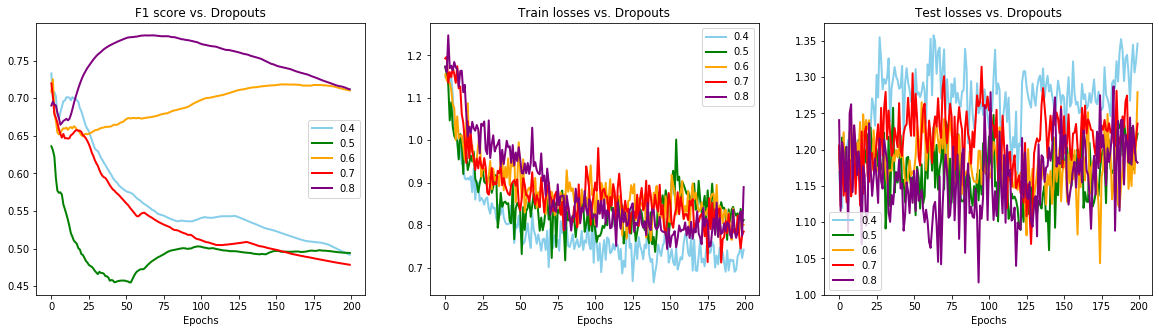

In [9]:
%run trainRNN_plot_utils.py
plot_inputs(F1_scores, trainLosses, testLosses, n_epoch)

In [10]:
# SAVE DATA
# Save the created samples, such tha the NNs can load them easily

# Save data into Python friendly file
import pickle
with open('resultsEncoderDropout_ANM.pickle', 'wb') as f:
    pickle.dump( trainLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( testLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( F1_scores, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainAccuracy, f, pickle.HIGHEST_PROTOCOL )
    print( 'Data saved into pickle.' )
    

Data saved into pickle.
